In [1]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from resnet import ResNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from custom_dataset import FinalDataset
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from FocalLoss import FocalLoss

In [2]:
file_path= "Dataset.hdf5"
dataset = FinalDataset(file_path ,downsample=True,majority_ratio=0.95)

In [4]:
# labels = dataset.get_labels()

In [5]:
# unique_classes, class_counts = np.unique(labels, return_counts=True)
# class_counts_dict = dict(zip(unique_classes, class_counts))
# class_counts_dict

In [6]:
# complete_dataset = FinalDataset(file_path)

In [7]:
# len(complete_dataset)

In [3]:
print(len(dataset))

163799


In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset.indices)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y).mean()
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f} [{batch * len(X):>5d}/{size:>5d}]")
    return total_loss / len(dataloader)


def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset.indices)
    total_loss = 0
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y).mean()
            total_loss += loss.item()
            all_preds.append(pred.cpu())
            all_targets.append(y.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    probabilities = torch.sigmoid(all_preds)

    targets = all_targets.int().numpy()

    for threshold in np.arange(0.1, 1.0, 0.1):
        print(f"\n==== Threshold: {threshold:.1f} ====")
        predicted = (probabilities > threshold).int().numpy()

        cm = confusion_matrix(targets, predicted)
        print("Confusion Matrix:")
        print(cm)
        
        report = classification_report(targets, predicted, digits=4, zero_division=0)
        print("Classification Report:")
        print(report)

    return total_loss / len(dataloader)



Parametri

In [5]:
# Focal loss parameters
gamma = 5.0
alpha = 0.95

# ResNet parameters
in_channels = 12
out_channels = 32

# Optimizer parameters
learning_rate = 1e-4
weight_decay = 1e-4

# K-fold cross-validation parameters
random_state = 42

# Training parameters
epochs = 40
batch_size = 64

In [ ]:
train_val_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.15,
    random_state=random_state,
    stratify=dataset.get_labels()
)
train_val_idx.sort()
test_idx.sort()
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.17647,  # ~15% of total
    random_state=random_state,
    stratify=dataset.labels[train_val_idx]
)

Epoch 1
-------------------------------
loss: 0.005059 [    0/114659]
loss: 0.043504 [ 6400/114659]
loss: 0.092234 [12800/114659]
loss: 0.008425 [19200/114659]
loss: 0.098165 [25600/114659]
loss: 0.004122 [32000/114659]
loss: 0.002980 [38400/114659]
loss: 0.014876 [44800/114659]
loss: 0.002366 [51200/114659]
loss: 0.002535 [57600/114659]
loss: 0.003483 [64000/114659]
loss: 0.001277 [70400/114659]
loss: 0.001546 [76800/114659]
loss: 0.001664 [83200/114659]
loss: 0.001242 [89600/114659]
loss: 0.002257 [96000/114659]
loss: 0.001597 [102400/114659]
loss: 0.003945 [108800/114659]

==== Threshold: 0.1 ====
Confusion Matrix:
[[    0 23343]
 [    0  1227]]
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     23343
           1     0.0499    1.0000    0.0951      1227

    accuracy                         0.0499     24570
   macro avg     0.0250    0.5000    0.0476     24570
weighted avg     0.0025    0.0499    0.0048     

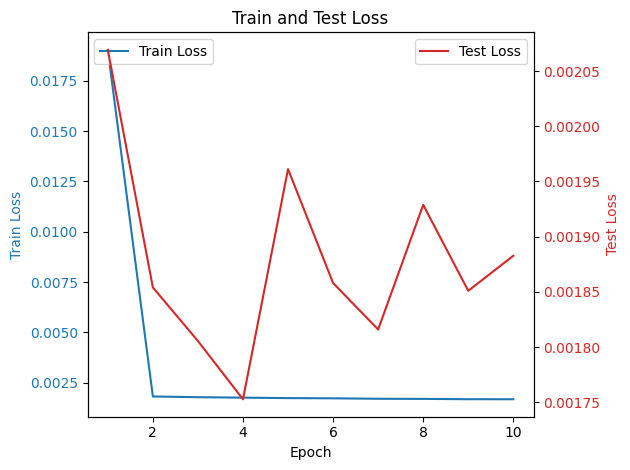

Saved model
Training Completed!


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset labels
labels = np.array(dataset.get_labels() ,dtype=np.int32)
labels = labels.squeeze()

# Class counts and pos_weight for BCEWithLogitsLoss
unique_classes, class_counts = np.unique(labels, return_counts=True)
class_counts_dict = dict(zip(unique_classes, class_counts))
print(f"Class counts: {class_counts_dict}")

pos_weight = torch.tensor(class_counts_dict[0] / class_counts_dict[1]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# loss_fn = nn.BCEWithLogitsLoss()

# loss_fn = FocalLoss(gamma, alpha)

# Model and optimizer
model = ResNet(in_channels, out_channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loader = DataLoader(FinalDataset("Dataset.hdf5", indices = dataset.indices[train_idx]), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(FinalDataset("Dataset.hdf5", indices = dataset.indices[val_idx]),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(FinalDataset("Dataset.hdf5", indices = dataset.indices[test_idx]),  batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
best_loss = float('inf')

patience, count = 5,0
# Single train/val loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, device)
    val_loss   = test_loop(val_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        count = 0
    else:
        count += 1

    if count > patience:
        print("Early stopping")
        break

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# Test after training
test_loss = test_loop(test_loader, model, loss_fn, device)
print(f"Final Test Loss: {test_loss:.4f}")
fig, ax1 = plt.subplots()

ax1.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='tab:blue')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.plot(range(1, len(val_losses) + 1), val_losses, label="Test Loss", color='tab:red')
ax2.set_ylabel("Test Loss", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f"Train and Test Loss")
plt.tight_layout()
plt.savefig(f"train_test_loss.png")
plt.show()

torch.save(model.state_dict(), f"model_moklesur.pth")
print(f"Saved model")

print("Training Completed!")
